### SHRED applied to Øresund

This iPython notebook gives an introductory walkthrough to using SHRED models.  

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio


num_sensors = 3 
lags = 52

sensor_locations = np.array([2849,   41, 2452])
np.save("Data/sensor_locations.npy",sensor_locations)


In [2]:
data_times = slice("2022-01-01", "2022-12-31")

# Load and save boundary data
ds = mikeio.read("Data/oresund/BC_SFC_North_2D_2014-2024.dfs1",time=data_times)
# ds.to_dfs("Data/oresund/BCn.dfs1")
ds.to_dfs("Data/oresund/BCn_1y.dfs1")
print(f"There are {ds.geometry.x.shape[0]} points in the North boundary")

ds = mikeio.read("Data/oresund/BC_SFC_South_2D_2014-2024.dfs1",time=data_times)
# ds.to_dfs("Data/oresund/BCs.dfs1")
ds.to_dfs("Data/oresund/BCs_1y.dfs1")
print(f"There are {ds.geometry.x.shape[0]} points in the South boundary")


There are 13 points in the North boundary
There are 29 points in the South boundary


In [3]:
ds = mikeio.read("Data/Area.dfsu",time=data_times)
# ds.to_dfs("Data/Area_5m.dfsu")
ds.to_dfs("Data/Area_1y.dfsu")
load_X = ds[0].to_numpy()
load_X.shape
n = load_X.shape[0]
m = load_X.shape[1]

In [4]:
south_node_coords = ds.geometry.node_coordinates[ds.geometry.codes==3,:2]
north_node_coords = ds.geometry.node_coordinates[ds.geometry.codes==2,:2]
np.save("Data/oresund/south_node_coords.npy", south_node_coords)
np.save("Data/oresund/north_node_coords.npy", north_node_coords)

We now select indices to divide the data into training, validation, and test sets.

In [5]:
# FRTP:
n_test = 174
n_valid = 174
n_train = 1000

train_indices = np.arange(0, n_train)
valid_test_indices = np.arange(n_train,n_train+n_valid)
test_indices = np.arange(n_train+n_valid,n_train+n_valid+n_test)


In [6]:
np.load("ForecastingResults/sensor_locations.npy")

array([2849,   41, 2452])

In [7]:
reconstruction = np.load('ReconstructingResults/reconstructions.npy')
truths = np.load('ReconstructingResults/truth.npy')
sensor_locations = np.load('ForecastingResults/sensor_locations.npy')

In [8]:
# Default from paper ?!?!?!
# Test Reconstruction Error: 
# 0.0193155

# When train and test are clearly separated:
# Test Reconstruction Error: 
# 0.04866559

In [9]:
def plot_reconstruction(reconstruction,truths,plot_index, sensor_coords, num_sensors=10, title="SHRED reconstruction"):
    
    # Create dataarrays for plotting
    da_plot_recon = ds[0].sel(time=ds.time[plot_index + lags - 1]).copy()
    da_plot_true = da_plot_recon.copy()
    da_plot_err = da_plot_recon.copy()
    # Fill with values from the reconstruction and the ground truth, as well as errors
    da_plot_recon.values = reconstruction[plot_index]
    da_plot_true.values = truths[plot_index]
    da_plot_err.values =  truths[plot_index]-reconstruction[plot_index]
    # min and max values for the colorbar
    vmin = -max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))
    vmax = max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))

    fig,axs = plt.subplots(1,3,figsize=(15,6))
    fig.suptitle('SHRED reconstruction of sensor data')

    vvmin = min(np.min(da_plot_true.values),np.min(da_plot_recon.values))
    vvmax = max(np.max(da_plot_true.values),np.max(da_plot_recon.values))

    da_plot_true.plot(ax = axs[1],vmin=vvmin,vmax=vvmax,add_colorbar=False)
    cbar = fig.colorbar(axs[1].collections[0], ax=axs[1],label='Surface elevation [m]')
    axs[1].set_title('Ground truth')

    da_plot_err.plot(ax = axs[2],cmap="bwr",vmin=vmin,vmax=vmax,add_colorbar=False)
    cbar = fig.colorbar(axs[2].collections[0], ax=axs[2],label='Error')
    axs[2].set_title('Error')

    da_plot_recon.plot(ax = axs[0],vmin=vvmin,vmax=vvmax,add_colorbar=False)
    cbar = fig.colorbar(axs[0].collections[0], ax=axs[0],label='Surface elevation [m]')
    axs[0].set_title(f'Reconstruction: {da_plot_recon.time[0].strftime("%d-%m-%Y %H:%M:%S")}')

    # Add a red dot to the spatial points indicated by the sensor locations
    for i in range(num_sensors):
        axs[0].scatter(sensor_coords[i,0], sensor_coords[i,1], color='red', s=40, label='Sensor location')
        axs[1].scatter(sensor_coords[i,0], sensor_coords[i,1], color='red', s=40, label='Sensor location')

    plt.tight_layout()

    rmspe = np.sqrt(np.mean(np.square((da_plot_err.values / da_plot_true.values)), axis=0))
    rmse = np.sqrt(np.mean(np.square((da_plot_err.values)), axis=0))

    return rmspe, rmse

def compute_RMSES(reconstruction,truths):
    # rmspe = np.sqrt(np.mean(np.square((truths-reconstruction)/truths)))
    rmse = np.sqrt(np.mean(np.square(truths-reconstruction)))
    std = np.std(np.sqrt(np.square(truths-reconstruction)))
    print('RMSE: ', rmse, 'STD: ', std)
    # print('RMSPE:', rmspe)

RMSE:  0.026333563 STD:  0.02256032


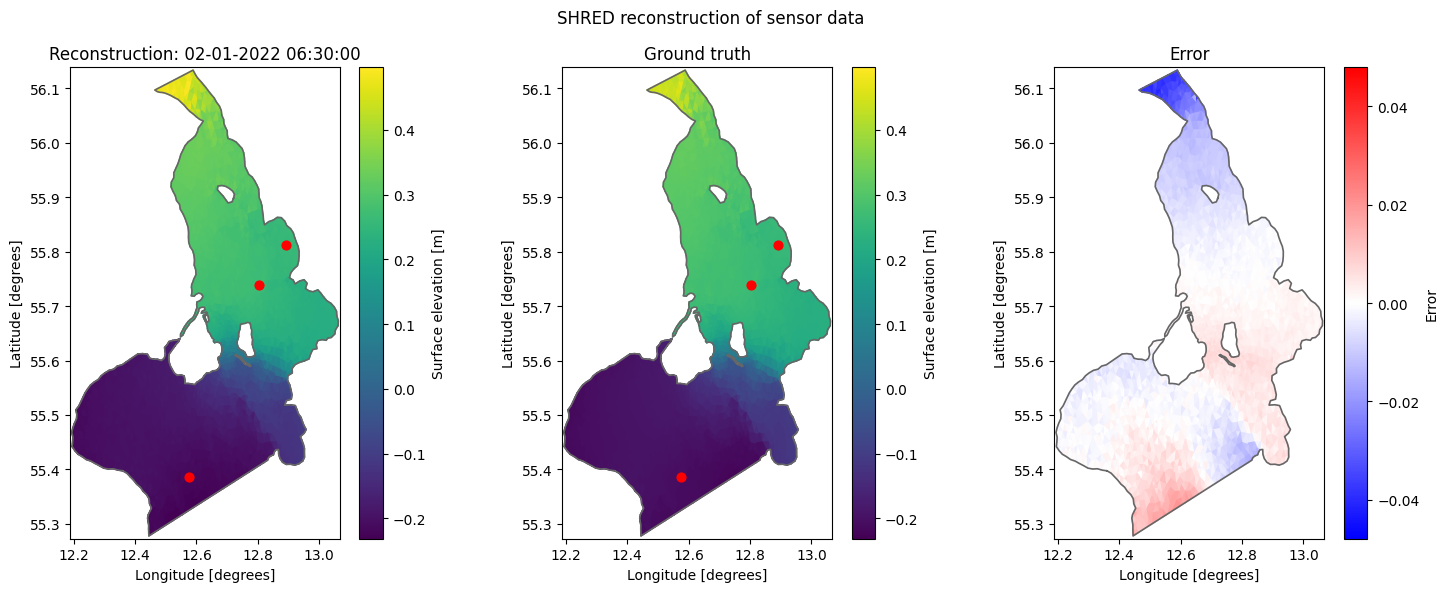

In [10]:
elem_cor = ds[0].geometry.element_coordinates
sensor_coords = elem_cor[sensor_locations]

plot_index = 10

rmspe, rmse = plot_reconstruction(reconstruction,truths,plot_index, sensor_coords, num_sensors=3)
compute_RMSES(reconstruction,truths)

## Reconstruction from forcing data

In [ ]:
# val_length = 500
# num_sensors = 6
# train_indices = np.arange(0, int(n*0.85))
# valid_indices = np.arange(int(n*0.85), int(n*0.85) + val_length)
# test_indices = np.arange(int(n*0.85) + val_length, n - lags)

# sensor_locations = np.load("ReconstructingResults/oresund_forcing/sensor_locations_forcing_sensor6lag52_1y.npy")
# sensor_locations

# reconstruction = np.load('ReconstructingResults/oresund_forcing/reconstructions_forcing_sensor6lag52_1y.npy')
# truths = np.load('ReconstructingResults/oresund_forcing/truth.npy')

# plot_index = 10
# sensor_coord = np.concatenate((ds[0].geometry.node_coordinates[ds[0].geometry.codes==2,:],
#                                ds[0].geometry.node_coordinates[(ds[0].geometry.codes==3)][1:-1]), axis=0)[sensor_locations]

# rmspe, rmse = plot_reconstruction(reconstruction,truths,plot_index, sensor_coord, num_sensors=6)
# compute_RMSES(reconstruction,truths)

# Run forecast with forcing SHRED model in 2023

In [22]:
import models
import torch
import pickle 

num_sensors = 6
val_length = 500
lags = 52
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sensor_locations = np.load("ReconstructingResults/oresund_forcing/sensor_locations_forcing_sensor6lag52_1y.npy")
sensor_coord = np.concatenate((ds[0].geometry.node_coordinates[ds[0].geometry.codes==2,:],
                               ds[0].geometry.node_coordinates[(ds[0].geometry.codes==3)][1:-1]), axis=0)[sensor_locations]

# Initialize model with trained parameters
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.0)
# Load weights of trained model
shred.load_weights("models/oresund_forcing/shred_reconstruction_forcing_sensor6lag52_1y.pt",device=device)

In [23]:
# Setup data
times = slice("2023-01-01", "2023-12-31")
ds = mikeio.read("Data/Area.dfsu",time=times, items=[0])
load_X = ds[0].to_numpy()
n = load_X.shape[0]
m = load_X.shape[1]
dsn = mikeio.read("Data/oresund/BC_SFC_North_2D_2014-2024.dfs1",time=times, items=[0])
dss = mikeio.read("Data/oresund/BC_SFC_South_2D_2014-2024.dfs1",time=times, items=[0])
load_y = np.concatenate((dsn.to_numpy().squeeze(), dss.to_numpy().squeeze()[:,1:-1]), axis=1)


sc = pickle.load(open("ReconstructingResults/oresund_forcing/scaler_forcing_sensor6lag52_1y.sav",'rb'))

sc_y = pickle.load(open("ReconstructingResults/oresund_forcing/scaler_y_forcing_sensor6lag52_1y.sav",'rb'))
sc_y = sc_y.fit(load_y)
transformed_y = sc_y.transform(load_y)


### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags+1, lags, num_sensors))
# Set up input data with lags
for i in range(len(all_data_in)):
# Use the forcing data as sensor input
    all_data_in[i] = transformed_y[i:i+lags, sensor_locations]


truths = load_X[lags - 1 :]

c:\Users\frtp\AppData\Local\miniforge3\envs\shred\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
# Perform forecast with SHRED:
# Corresponds to a reconstruction from the forcing data to the full domain
reconstruction = sc.inverse_transform(shred(torch.tensor(all_data_in, dtype=torch.float32).to(device)).detach().numpy())

In [25]:
plt.rcParams['font.size'] = 10

RMSE:  0.066293515 STD:  0.03577329


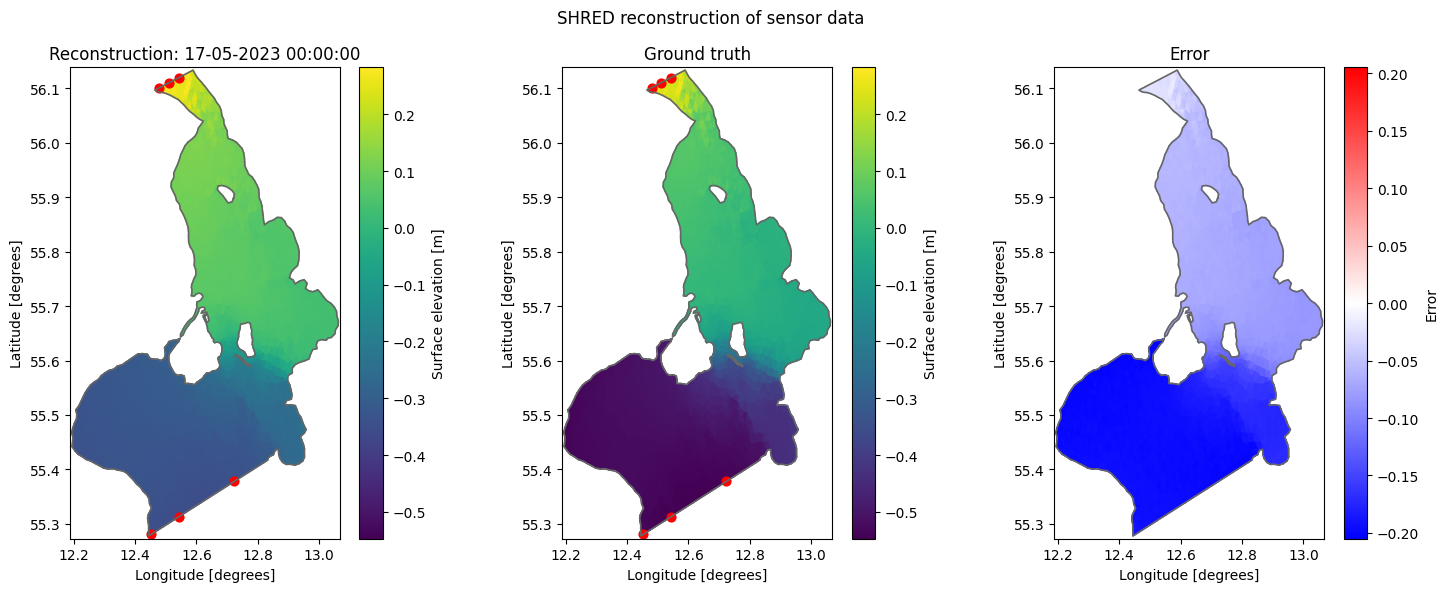

In [26]:
plot_index = 6477
rmspe, rmse = plot_reconstruction(reconstruction,truths,plot_index, sensor_coord, num_sensors=6)
compute_RMSES(reconstruction,truths)

In [27]:
from plotting import plot_RMSE_spatial,plot_abs_err_quantiles,plot_scatter

ds_true = ds.sel(time=ds.time[np.arange(lags-1, n)])
ds_pred = ds_true.copy()
ds_pred[0].values = reconstruction

ds_true

<mikeio.Dataset>
dims: (time:17468, element:3320)
time: 2023-01-02 01:30:00 - 2023-12-31 23:00:00 (17468 records)
geometry: Dfsu2D (3320 elements, 1916 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)

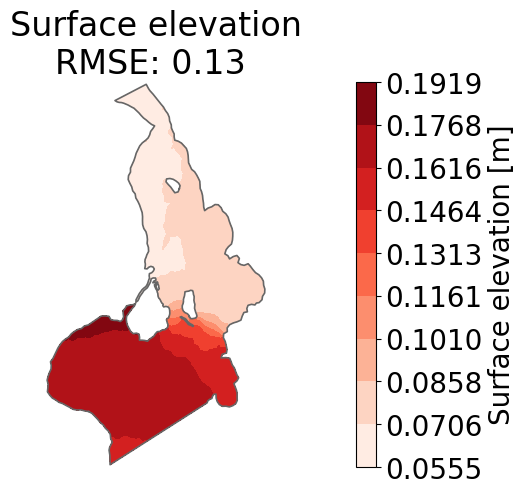

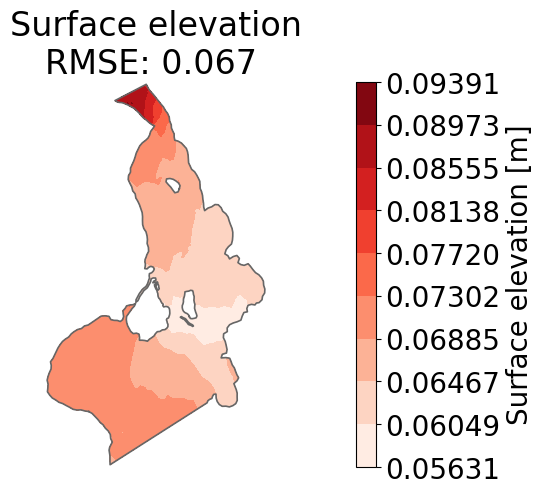

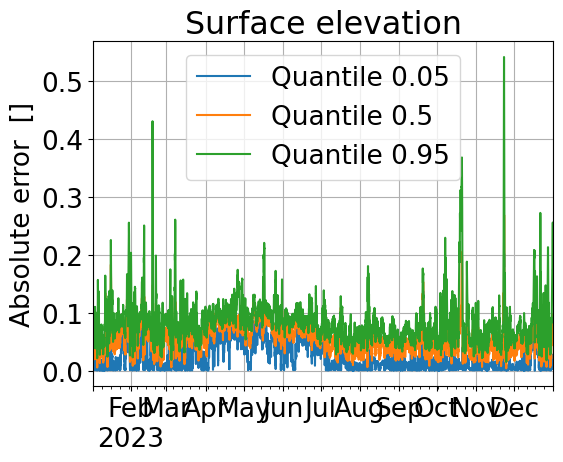

<Figure size 640x480 with 0 Axes>

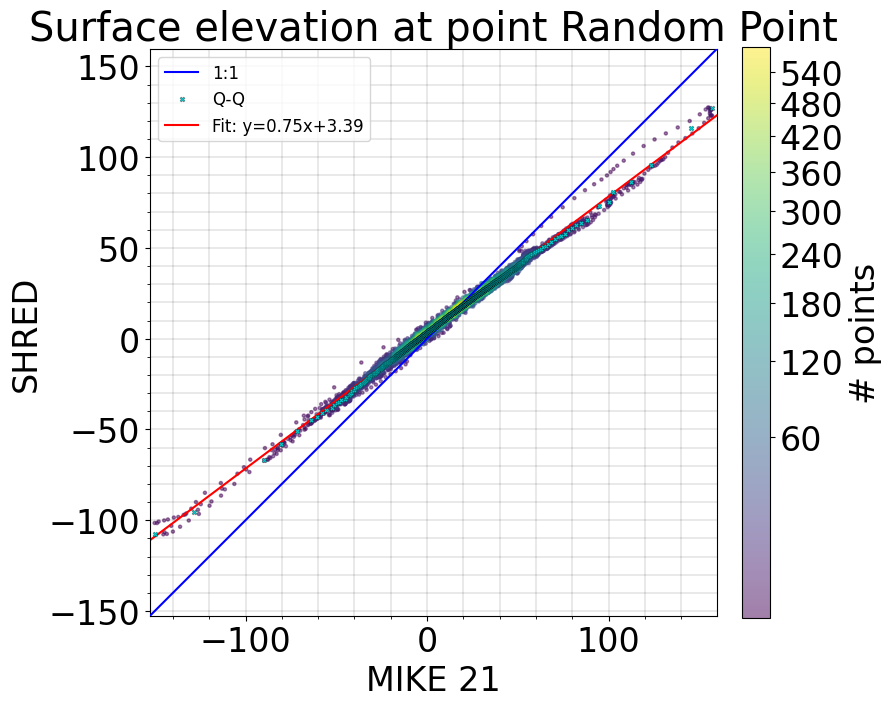

In [28]:
date = "17-05-2023"
plot_RMSE_spatial(ds_pred.sel(time=date),ds_true.sel(time=date), None, config=None, fig_name_prefix="",cmap_err="Reds",save_fig = False, show_fig = True,var_names=None)
plot_RMSE_spatial(ds_pred,ds_true, None, config=None, fig_name_prefix="",cmap_err="Reds",save_fig = False, show_fig = True,var_names=None)
plot_abs_err_quantiles(ds_pred,ds_true,fig_path=None,fig_name_prefix="",config=None,save_fig = False, show_fig = True,var_names=None,q=[0.05,0.5,0.95])
config = {'plot_point_position': [12.5,55.5],
          'plot_point_name': "Random Point",}
plot_scatter(ds_pred,ds_true,mod_name="SHRED",fig_path=None,fig_name_prefix="",config=config,save_fig=False, show_fig=True,var_names=None)

In [ ]:
compute_RMSES(ds_pred[0].values,ds_true[0].values)

# When trained on 5m data: 
# RMSE:  0.06335456
# RMSPE: 2130.2163

# When trained on 1y data:
# RMSE:  0.06720423

RMSE:  0.066293515 STD:  0.03577329


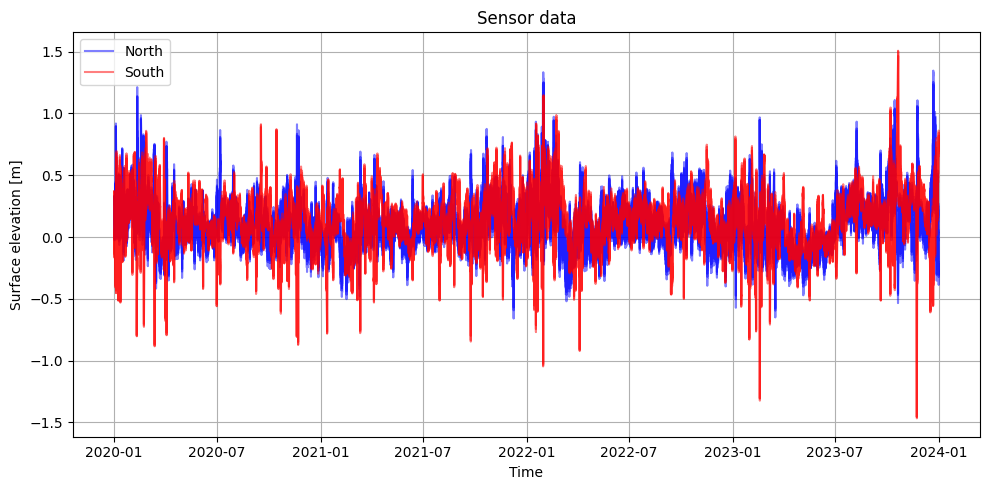

In [ ]:
times = slice("2020-01-01", "2023-12-31")
dsn = mikeio.read("Data/oresund/BC_SFC_North_2D_2014-2024.dfs1",time=times, items=[0])
dss = mikeio.read("Data/oresund/BC_SFC_South_2D_2014-2024.dfs1",time=times, items=[0])

# Plot sensor data
sensor_locations = np.load("ReconstructingResults/oresund_forcing/sensor_locations_forcing_sensor6lag52_1y.npy")
sensor_data = np.concatenate((dsn[0].values, dss[0].values[:,1:-1]),axis=1)[:,sensor_locations]
# Make plots of the sensor data
# with ds_pred.time as time axis. 
# Sensor data is a line plot. Colored such that the first three sensors are blue, and the last three are red. Labelled 'North' and 'South' respectively.
# use sensor_data for plotting.
plt.rcParams['font.size'] = 10
plt.figure(figsize=(10, 5))
plt.plot(dsn.time, sensor_data[:,:3], color='blue', label='North', alpha=0.5)
plt.plot(dsn.time, sensor_data[:,3:], color='red', label='South', alpha=0.5)
plt.title('Sensor data')
plt.xlabel('Time')
plt.ylabel('Surface elevation [m]')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.vlines(x=pd.to_datetime("17-05-2023",dayfirst=True),ymin=-1.5,ymax=1.5, color='black', linestyle='--')
plt.grid()
plt.tight_layout()
